# Prestige Reinforcement Dynamics

This notebook provides a simple version of an asynchronous model of prestige-reinforcement in networked endorsement dynamics, as exemplified by the faculty hiring process. 

This notebook is intentionally designed to expose all calculations, so all functions etc. (other than SpringRank) are defined in here directly. 

In [6]:
import numpy as np

from py.simulation import *
from py.estimation import *
from py.features import *
from py.utils import *
from py.learner import *

from SpringRank import SpringRank

from matplotlib import pyplot as plt

In [196]:
n_rounds = 400
n = 70
m_updates = 3

# A = np.random.randint(10, size = (n, n))
A = np.random.randint(10, size = (n,n))
A0 = A/A.sum()*m_updates*n

beta = np.array([2.9])
lam = .9

alpha = .1

In [189]:
L = learner()

def SR_homebrew(A, alpha = 0):
    n = A.shape[0]
    
    d_i = A.sum(axis = 0)
    d_o = A.sum(axis = 1)
    D_i = np.diag(d_i)
    D_o = np.diag(d_o)
    
    L = D_i + D_o - A - A.T 
    
    return(np.linalg.inv(L + alpha*np.eye(n)).dot(d_o - d_i))

L.set_score(
#     score_function = lambda A: A.sum(axis = 0)**.5
    score_function = lambda A: SR_homebrew(A.T, alpha = alpha)
)

def quadratic_feature(s):
    S = np.tile(s, (n,1))
    F = (S - S.T)**2
    return(F)

L.set_features([
    lambda s: np.tile(s, (n,1)),
#     quadratic_feature,
])

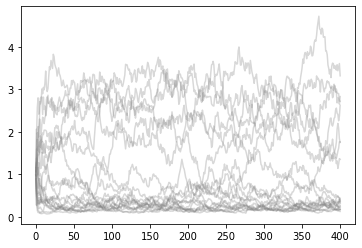

In [190]:
# generate some fake data

T = L.simulate(beta = beta, 
               lam = lam, 
               A0 = A0,
               n_rounds = n_rounds,
               update = stochastic_update,
               m_updates = m_updates)

L.set_data(T, T[0])
L.compute_state_matrix(lam = lam)
L.compute_score()
L.compute_features()
L.compute_rate_matrix(beta = beta)

p = plt.plot(L.GAMMA.sum(axis = 1), color = 'grey', alpha = .3)

In [587]:
n = 2
A = np.ones((n,n)) + .001*np.random.randint(10, size = (n,n))

A0 = A/A.sum()

def bifurcation_trial(beta, n = 2, n_rounds = 500, lam = .99, m_updates = 1, alpha = .01):
    
    L.set_score(score_function = lambda A: SR_homebrew(A.T, alpha = alpha))
    T = L.simulate(beta = beta, 
                   lam = lam, 
                   A0 = A0, 
                   n_rounds = n_rounds, 
                   update = deterministic_update, 
                   m_updates = m_updates)
    
    L.set_data(T, T[0])
    L.compute_state_matrix(lam = lam)
    L.compute_score()
    L.compute_features()
    L.compute_rate_matrix(beta = beta)
    return(L.GAMMA[-1].mean(axis = 0))

In [588]:
BETAS = np.linspace(0.0,5.0, 101)

V = np.array([bifurcation_trial(np.array([beta]), 
                                m_updates = 1,
                                lam = .98,
                                n_rounds = 5000) for beta in BETAS])

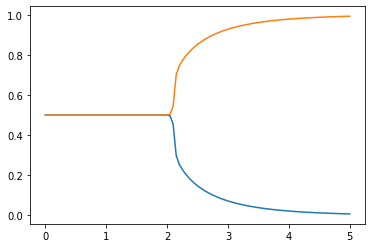

In [589]:
p = plt.plot(BETAS, V)
# plt.vlines(2, ymin = 0, ymax = 1)

In [583]:
n = 20

def estimate(beta, alpha, n = 6):
    
    E = np.ones((n,n))
    I = np.eye(n, n)
    
    L_ = 2/n*(I - E/n)
    
    dF = (2 - beta)*(I - 1/n*E) - L_
    M = np.linalg.inv(L_ + alpha*I).dot(dF)
    
    eig = np.linalg.eig(M)[0]
    eig = np.sort(eig)
    return(eig[-2])
#     return(eig[-1])

In [584]:
print(2 - 2/n, estimate(2-2/n, alpha, n))

1.9 4.336808689942019e-16


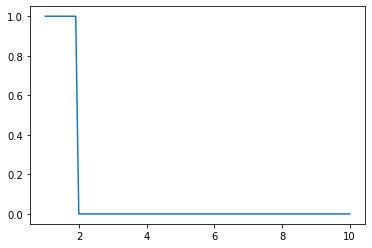

In [585]:
# BETAS
BETAS = np.linspace(1, 10, 101)

v = np.array([estimate(beta, alpha = 0.1, n = n) for beta in BETAS])
plt.plot(BETAS, v > 0)
# plt.ylim(0,1000)